In [19]:
import collections
import glob
import warnings

import numpy as np

warnings.filterwarnings("ignore")
import random
from collections import defaultdict

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from utils_parallel_syn_gradient import *
# rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})/

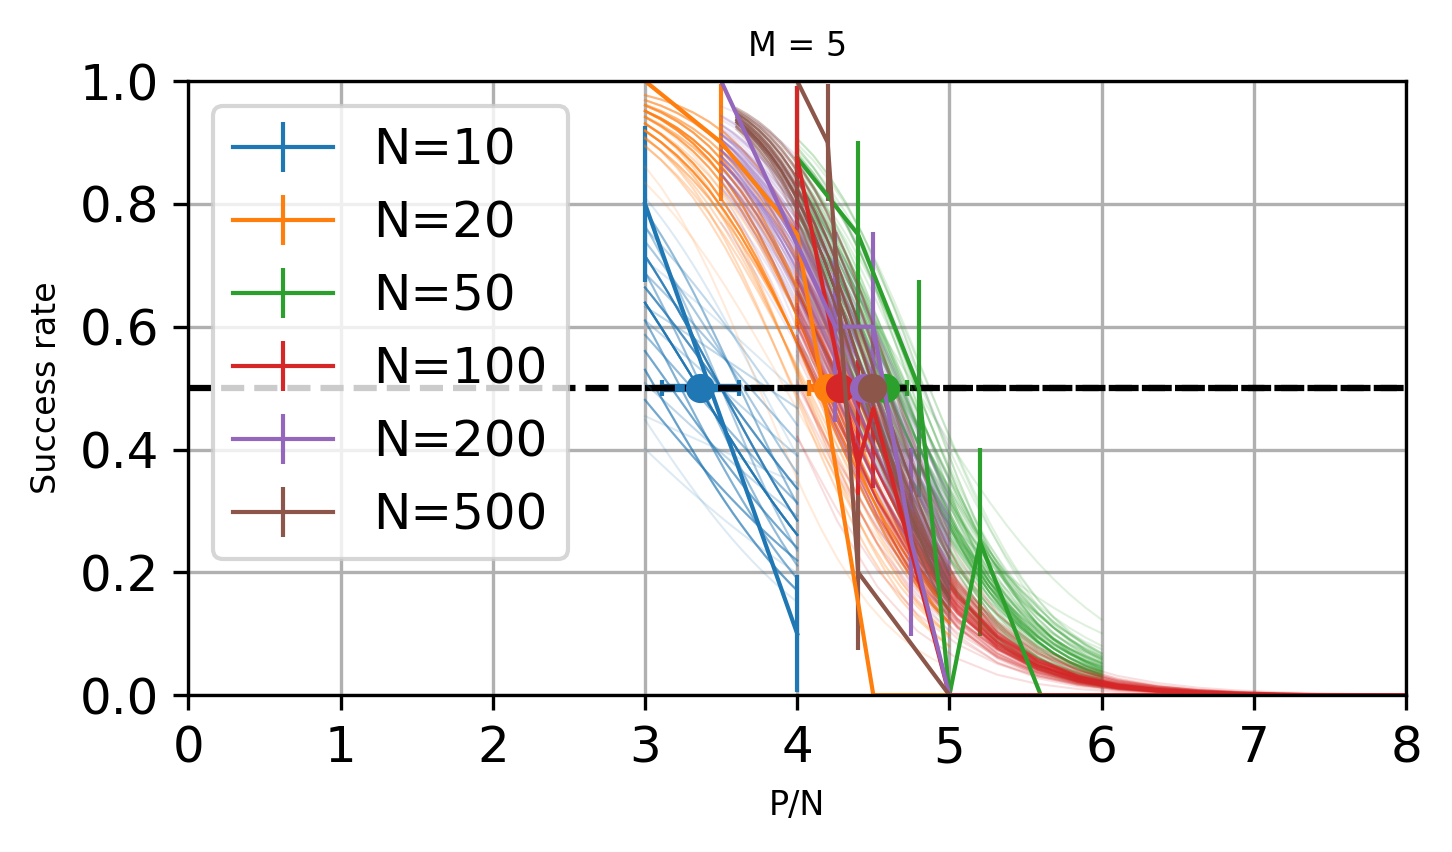

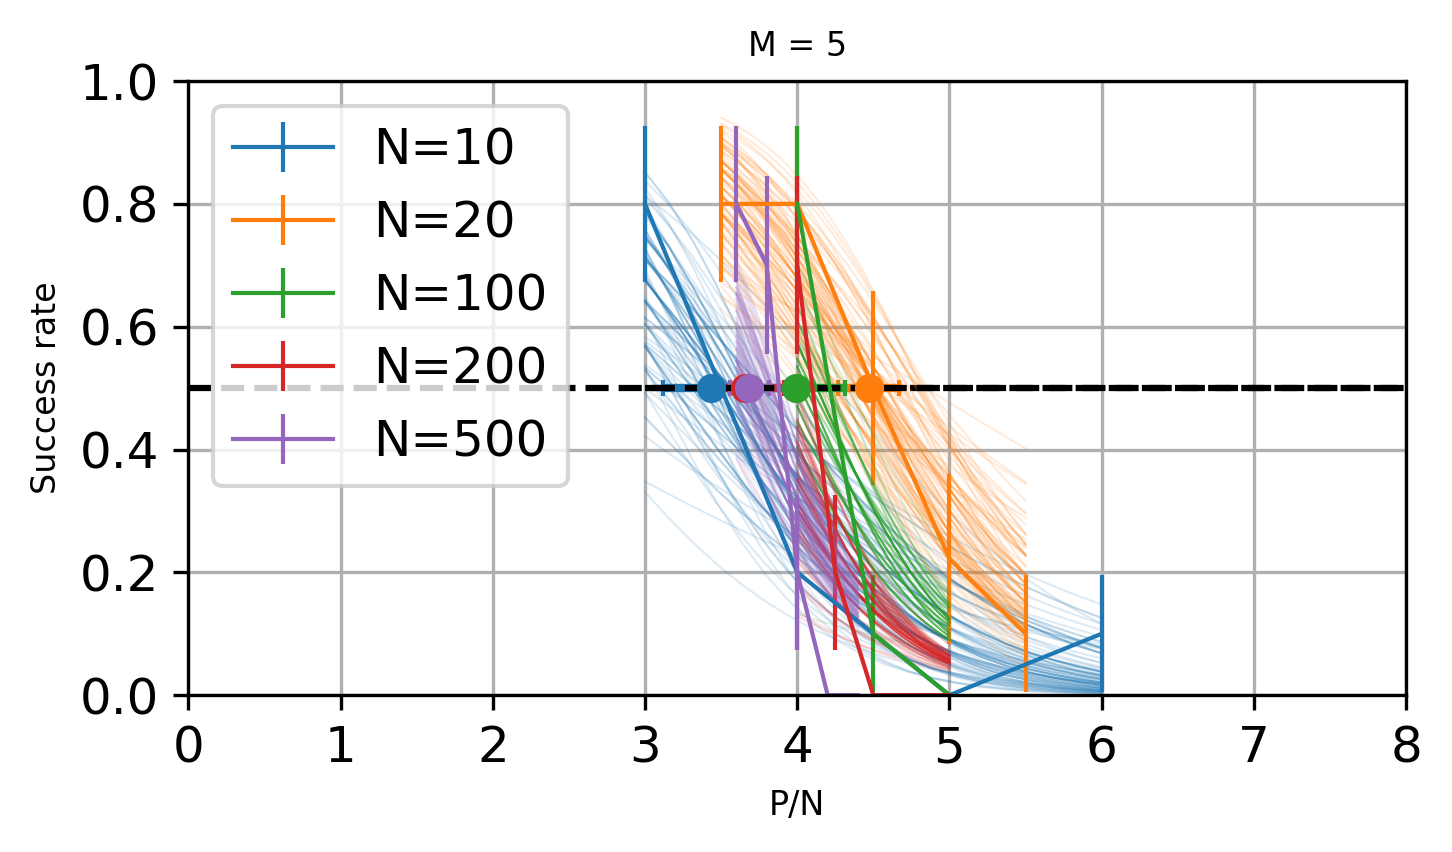

In [20]:
all_count_trial_dict = defaultdict(dict)
all_capacity_dict = defaultdict(dict)
for n_repeat in [20, 50]:
    experi = {}
    allN = set()
    allM = set()

    for N in [10, 20, 50, 100, 200, 500]:
        path = glob.glob(
            "./N_" + str(N) + "_noise_png/*seed_[0-9]*_repeat_" + str(n_repeat) + ".png"
        ) + glob.glob(
            "./N_"
            + str(N)
            + "_noise_png/*seed_[0-9]*_repeat_"
            + str(n_repeat)
            + "_noisy_train_true.png"
        )

        for p_ in path:
            params = p_.split("/")[-1].replace(".png", "").split("_")

            N_, M_, P_, seed_ = (
                int(params[1]),
                int(params[3]),
                int(params[5]),
                int(params[7]),
            )
            if M_ not in [5]:
                continue
            if (N_, M_) not in experi:
                experi[(N_, M_)] = {}
            if P_ not in experi[(N_, M_)]:
                experi[(N_, M_)][P_] = np.ones((20,), dtype=int) * np.nan

            if experi[(N_, M_)][P_][seed_] > 0:
                continue
            else:
                experi[(N_, M_)][P_][seed_] = int(params[-1] == "true")

            if N_ not in allN:
                allN.add(N_)
            if M_ not in allM:
                allM.add(M_)

        for N_, M_ in experi:
            for P_ in experi[(N_, M_)]:
                experi[(N_, M_)][P_] = experi[(N_, M_)][P_][
                    ~np.isnan(experi[(N_, M_)][P_])
                ]
            experi[(N_, M_)] = collections.OrderedDict(sorted(experi[(N_, M_)].items()))

    arrayN = np.array(sorted(list(allN)))
    arrayM = np.array(sorted(list(allM)))
    countTrialDict = {}
    for N in arrayN:
        for M in arrayM:
            if (N, M) in experi:
                countTrial = []
                for k in experi[(N, M)]:
                    countTrial.append(
                        (
                            k,
                            k / N,
                            len(experi[(N, M)][k]),
                            sum(experi[(N, M)][k]) / len(experi[(N, M)][k]),
                        )
                    )
                countTrialDict[(N, M)] = countTrial
            else:
                countTrialDict[(N, M)] = []

    for N, M in countTrialDict:
        if M != 10:
            continue
        print("N, M:", N, M, " P, alpha, count, rate: ")
        print(countTrialDict[(N, M)])
        print("----")
    all_count_trial_dict[n_repeat] = countTrialDict
    plt.figure(figsize=(5, 3), dpi=300)
    plt.plot([3, 14], [0.5, 0.5], "k--")
    c = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
    ]

    arrayN = np.array(sorted(list(allN)))
    arrayM = np.array(sorted(list(allM)))
    capacity = {}
    for count, (N, M) in enumerate(experi):
        if M not in [5]:
            continue
        if M not in capacity:
            capacity[M] = []

        sample = 100
        psedoC = []
        for i in range(sample):
            psedoX = []
            psedoY = []

            for P in experi[(N, M)]:
                psedoX += [P / N] * len(experi[(N, M)][P])
                psedoY += random.choices(experi[(N, M)][P], k=len(experi[(N, M)][P]))
            if min(psedoY) == max(psedoY):
                continue
            clf = LogisticRegression().fit(
                np.array(psedoX).reshape(-1, 1), np.array(psedoY)
            )
            newX = np.linspace(
                min(experi[(N, M)].keys()) / N, max(experi[(N, M)].keys()) / N, 20
            )
            if np.abs(-clf.intercept_[0] / clf.coef_[0][0]) > 20:
                continue
            psedoC.append(-clf.intercept_[0] / clf.coef_[0][0])

            probs = clf.predict_proba(newX.reshape(-1, 1))

            plt.subplot(arrayM.size, 1, np.where(arrayM == M)[0][0] + 1)
            plt.plot(
                newX,
                probs[:, 1],
                alpha=0.15,
                linewidth=0.5,
                color=c[np.where(arrayN == N)[0][0]],
            )

        capacity[M].append(
            [N, M, np.nanmean(np.array(psedoC)), np.nanstd(np.array(psedoC))]
        )

        plt.subplot(arrayM.size, 1, np.where(arrayM == M)[0][0] + 1)
        plt.errorbar(
            np.array(list(experi[(N, M)].keys())) / N,
            [np.mean(np.array(experi[(N, M)][P])) for P in experi[(N, M)]],
            yerr=[
                np.std(np.array(experi[(N, M)][P])) / np.sqrt(len(experi[(N, M)][P]))
                for P in experi[(N, M)]
            ],
            label="N=" + str(N),
            linewidth=1,
            color=c[np.where(arrayN == N)[0][0]],
        )

        plt.errorbar(
            [np.array(psedoC).mean()],
            [0.5],
            xerr=np.array(psedoC).std(),
            fmt="o",
            linewidth=2,
            capsize=2,
            color=c[np.where(arrayN == N)[0][0]],
        )
    for i in range(arrayM.size):
        plt.subplot(arrayM.size, 1, i + 1)
        plt.title("M = " + str(arrayM[i]), fontsize=8)
        plt.legend()
        plt.xlim([0, 8])
        plt.ylim([0, 1])
        plt.plot([0, 8], [0.5, 0.5], "k--")
        plt.grid()
        plt.xlabel("P/N", fontsize=8)
        plt.ylabel("Success rate", fontsize=8)
    for M in capacity:
        capacity[M] = np.array(capacity[M])
    capacity = collections.OrderedDict(sorted(capacity.items()))

    plt.tight_layout()

    plt.savefig("success_rate.pdf")
    plt.show()

    all_capacity_dict[n_repeat] = capacity

In [21]:
all_count_trial_dict
# all_capacity_dict .
# n_repeat = 50 ;{(100, 5): [(400, 4.0, 10, 0.6), (450, 4.5, 10, 0.1), (500, 5.0, 10, 0.0)]}

defaultdict(dict,
            {20: {(10, 5): [(30, 3.0, 10, 0.8), (40, 4.0, 10, 0.1)],
              (20, 5): [(60, 3.0, 8, 1.0),
               (70, 3.5, 10, 0.9),
               (80, 4.0, 8, 0.75),
               (90, 4.5, 4, 0.0),
               (100, 5.0, 6, 0.0)],
              (50, 5): [(200, 4.0, 8, 0.875),
               (220, 4.4, 8, 0.75),
               (240, 4.8, 8, 0.5),
               (250, 5.0, 8, 0.0),
               (260, 5.2, 8, 0.25),
               (280, 5.6, 8, 0.0),
               (300, 6.0, 8, 0.0)],
              (100, 5): [(400, 4.0, 8, 0.875),
               (440, 4.4, 8, 0.375),
               (450, 4.5, 15, 0.4666666666666667),
               (500, 5.0, 15, 0.0),
               (600, 6.0, 8, 0.0),
               (800, 8.0, 8, 0.0),
               (900, 9.0, 8, 0.0)],
              (200, 5): [(700, 3.5, 10, 1.0),
               (850, 4.25, 10, 0.6),
               (900, 4.5, 10, 0.6),
               (950, 4.75, 8, 0.25),
               (1000, 5.0, 8, 0.0)],
 

# plot final result

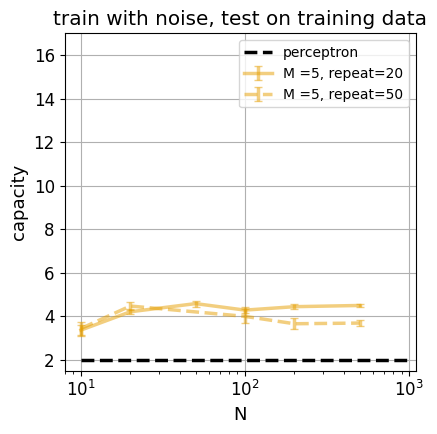

In [22]:
ax = plt.figure(figsize=(4.5, 4.5))
color = ["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
line = ["-", "--", "-.", ":"]
# plt.errorbar(capacity1[:, 0], capacity1[:, 2], yerr = capacity1[:, 3], capsize = 2, color = 'k', label = 'M = 5')
for i_repeat, k in enumerate(all_capacity_dict):
    capacity = all_capacity_dict[k]
    for i, M in enumerate(capacity):
        x, y, yerr = capacity[M][:, 0], capacity[M][:, 2], capacity[M][:, 3]
        plt.errorbar(
            x[~np.isnan(y)],
            y[~np.isnan(y)],
            yerr=yerr[~np.isnan(y)],
            capsize=3,
            color=color[i],
            label="M =" + str(M) + ", repeat=" + str(k),
            linestyle=line[i_repeat],
            linewidth=2.5,
            alpha=0.5,
        )
    # plt.errorbar(
    #     capacityms[:, 0],
    #     capacityms[:, 1],
    #     yerr=capacityms[:, 2],
    #     capsize=3,
    #     color="r",
    #     label="unlimited",
    #     linewidth=3,
    # )
plt.plot(
    np.logspace(1, 3, 5), np.ones((5,)) * 2, "k--", linewidth=2.5, label="perceptron"
)
plt.xscale("log")
# plt.yscale('log')
# plt.xticks([0 + i*100 for i in range(12)])
plt.grid()

plt.xlabel("N", fontsize=13)
plt.ylabel("capacity", fontsize=13)
plt.ylim([1.5, 17])

plt.xlim([-10, 1.1e3])
plt.legend(ncol=1, prop={"size": 10})
# plt.grid()
plt.title("train with noise, test on training data")
plt.tight_layout()


plt.savefig("capacity_noisy_train.pdf")